In [136]:
#preparation
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score, validation_curve, train_test_split
from sklearn.metrics import roc_curve, confusion_matrix, f1_score,roc_auc_score, accuracy_score, recall_score, precision_score
from sklearn.utils import resample

In [3]:
data = pd.read_stata("data/ESS8e02_2.dta", convert_categoricals=False) #data in dta format 

In [8]:
data.shape #dimensionality 

(44387, 535)

In [32]:
df = data[['cntry',
          'nwspol','netustm','ppltrst', #media and social trust
          'polintr','trstprt','trstplt', #politics 
          'happy','atchctr','rlgdgr','brncntr','ctzcntr', #social values 
          'eneffap','clmchng','wrpwrct','wrenexp', #climate change 
          'gndr','hhmmb','agea','eduyrs','wkhtot']] #others 

In [33]:
df = df.dropna() #drop missing data

In [34]:
df.shape #new dimensionality 

(24820, 21)

In [35]:
df.describe() #get an overlook of the numeric data 

,nwspol,netustm,ppltrst,polintr,trstprt,trstplt,happy,atchctr,rlgdgr,brncntr,ctzcntr,eneffap,clmchng,wrpwrct,wrenexp,gndr,hhmmb,agea,eduyrs,wkhtot
count,24820.000000,24820.000000,24820.000000,24820.000000,24820.000000,24820.000000,24820.000000,24820.000000,24820.000000,24820.000000,24820.000000,24820.000000,24820.000000,24820.000000,24820.000000,24820.000000,24820.000000,24820.000000,24820.000000,24820.000000
mean,78.117446,195.663537,5.566761,2.437188,3.837631,3.836583,7.713860,7.723650,4.100927,1.104311,1.047019,7.906326,1.469742,2.149194,3.029492,1.506205,2.756567,44.728928,14.264907,39.706809
std,126.200351,173.375723,2.233971,0.895325,2.312571,2.344595,1.633558,2.150615,3.063928,0.305670,0.211683,2.170882,0.651123,0.949181,1.008494,0.499972,1.345494,15.570526,3.534051,15.004829
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.000000,0.000000,0.000000
25%,30.000000,60.000000,4.000000,2.000000,2.000000,2.000000,7.000000,7.000000,1.000000,1.000000,1.000000,7.000000,1.000000,1.000000,2.000000,1.000000,2.000000,32.000000,12.000000,35.000000
50%,60.000000,120.000000,6.000000,2.000000,4.000000,4.000000,8.000000,8.000000,4.000000,1.000000,1.000000,8.000000,1.000000,2.000000,3.000000,2.000000,2.000000,44.000000,14.000000,40.000000
75%,90.000000,240.000000,7.000000,3.000000,6.000000,6.000000,9.000000,9.000000,7.000000,1.000000,1.000000,10.000000,2.000000,3.000000,4.000000,2.000000,4.000000,56.000000,17.000000,45.000000
max,1428.000000,1440.000000,10.000000,4.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,2.000000,10.000000,4.000000,5.000000,5.000000,2.000000,20.000000,97.000000,54.000000,168.000000


In [36]:
#data preprocessing 

df['polintr'] = df['polintr'].replace([1.0,2.0,3.0,4.0],[4,3,2,1])
df['ctzcntr'] = df['ctzcntr'].replace(2,0)
df['brncntr'] = df['brncntr'].replace(2,0)

df.loc[df.clmchng == 3, 'clmchng'] = 0
df.loc[df.clmchng == 4, 'clmchng'] = 0
df.loc[df.clmchng == 2, 'clmchng'] = 1

df = pd.get_dummies(df, columns=['gndr'], drop_first=True) #gender2=female

In [37]:
#balance check for target variable
df['clmchng'].value_counts()

1.0    23432
0.0     1388
Name: clmchng, dtype: int64

#### data viz for preliminary analysis

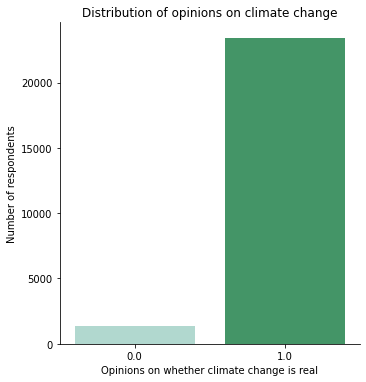

In [38]:
sns.catplot(x="clmchng", kind="count", palette = "BuGn", data=df)
plt.title('Distribution of opinions on climate change')
plt.xlabel('Opinions on whether climate change is real')
plt.ylabel('Number of respondents')
plt.show()
#plt.savefig('Viz/Opinion.png', dpi = 300, bbox_inches='tight')

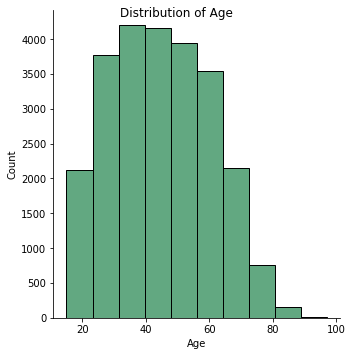

In [39]:
sns.displot(df, x="agea", bins = 10, color = "seagreen")
plt.suptitle("Distribution of Age")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()
#plt.savefig("Viz/age.png", dpi = 300, bbox_inches = "tight")

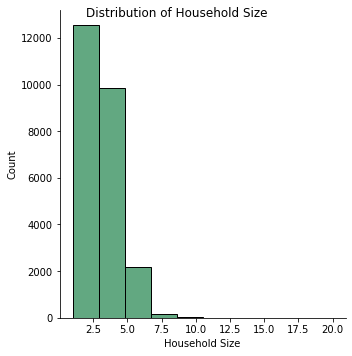

In [23]:
sns.displot(df, x="hhmmb", bins = 10, color = "seagreen")
plt.suptitle("Distribution of Household Size")
plt.xlabel("Household Size")
plt.ylabel("Count")
#plt.show()
plt.savefig("Viz/hh.png", bbox_inches = "tight", dpi = 300)

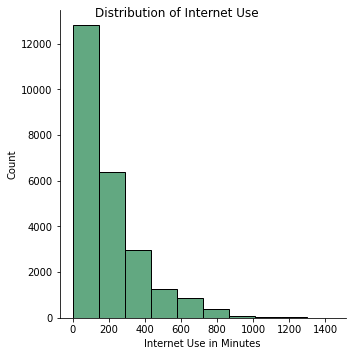

In [24]:
sns.displot(df, x="netustm", bins = 10, color = "seagreen")
plt.suptitle("Distribution of Internet Use")
plt.xlabel("Internet Use in Minutes")
plt.ylabel("Count")
#plt.show()
plt.savefig("Viz/internet.png", bbox_inches = "tight", dpi = 300)

In [40]:
df['hhmmb'] = np.log(df['hhmmb']) #log transform household size

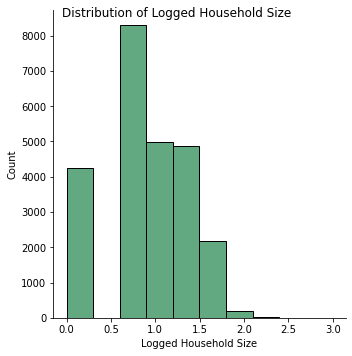

In [41]:
sns.displot(df, x="hhmmb", bins = 10, color = "seagreen")
plt.suptitle("Distribution of Logged Household Size")
plt.xlabel("Logged Household Size")
plt.ylabel("Count")
#plt.show()
plt.savefig("Viz/hh_log.png", bbox_inches = "tight", dpi = 300)

In [42]:
df['netustm'] = np.log(df['netustm']+1) #log transform internet use 

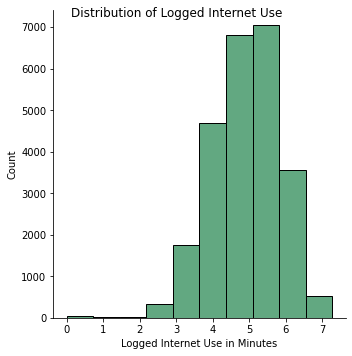

In [43]:
sns.displot(df, x="netustm", bins = 10, color = "seagreen")
plt.suptitle("Distribution of Logged Internet Use")
plt.xlabel("Logged Internet Use in Minutes")
plt.ylabel("Count")
#plt.show()
plt.savefig("Viz/internet_logged.png", bbox_inches = "tight", dpi = 300)

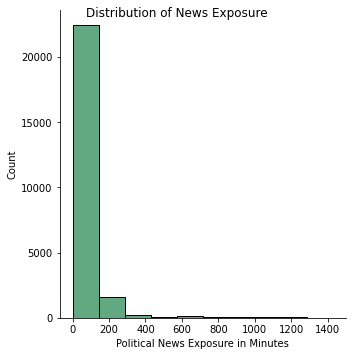

In [44]:
#create a graph 
sns.displot(df, x="nwspol", bins = 10, color = "seagreen")
plt.suptitle("Distribution of News Exposure")
plt.xlabel("Political News Exposure in Minutes")
plt.ylabel("Count")
#plt.show()
plt.savefig("Viz/news.png", bbox_inches = "tight", dpi = 300)

In [45]:
df['nwspol'] = np.log(df['nwspol']+1) #log transform news exposure 

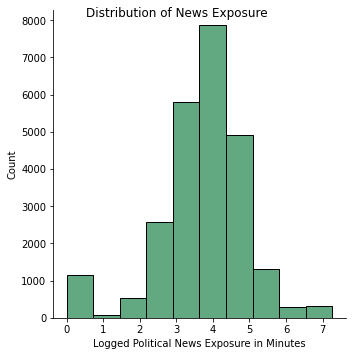

In [46]:
sns.displot(df, x="nwspol", bins = 10, color = "seagreen")
plt.suptitle("Distribution of News Exposure")
plt.xlabel("Logged Political News Exposure in Minutes")
plt.ylabel("Count")
#plt.show()
plt.savefig("Viz/newslog.png", bbox_inches = "tight", dpi = 300)

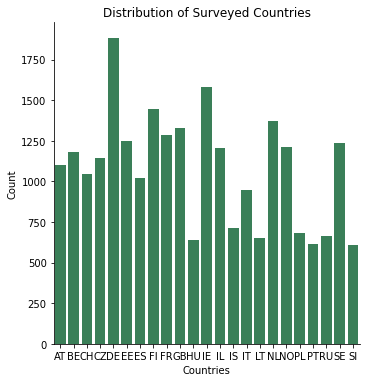

In [47]:
#countries

sns.catplot(x="cntry", kind="count", color = "seagreen", data=df)
plt.title('Distribution of Surveyed Countries')
plt.xlabel('Countries')
plt.ylabel('Count')
#plt.show()
plt.savefig('Viz/countries.png', dpi = 300, bbox_inches='tight')


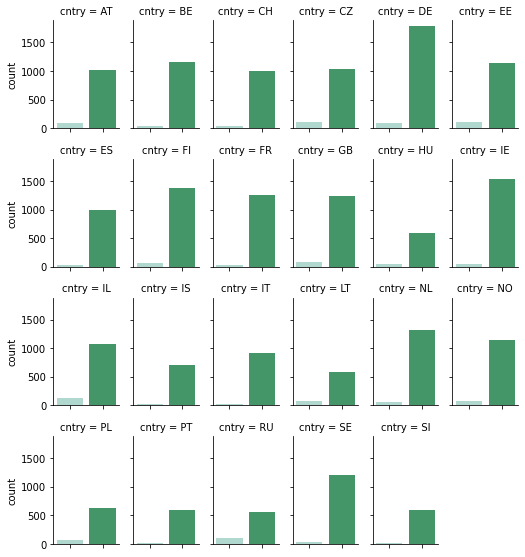

In [71]:
sns.catplot(x="clmchng", col ="cntry", data = df, kind="count",
        height=2, aspect=0.6,  col_wrap=6,
           palette = "BuGn").set(xlabel = None, xticklabels=[])
plt.savefig('Viz/countriesVSclm.png', dpi = 300, bbox_inches='tight')

In [72]:
cor = df.select_dtypes(include="float64").corr() #correlation matrix

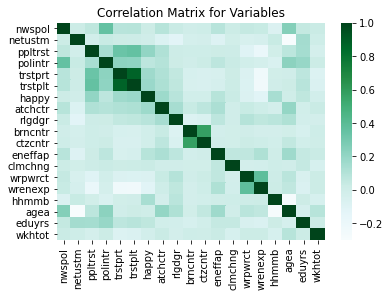

In [73]:
ax = plt.axes()
sns.heatmap(cor, cmap = 'BuGn')
ax.set_title('Correlation Matrix for Variables')
plt.savefig("Viz/corr.png", dpi = 300, transparent=True, bbox_inches='tight')

#### Statistical Learning

In [79]:
df = pd.get_dummies(df, columns = ['cntry']) #create dummies for countries

In [80]:
#address the class imbalance
df_majority = df[df.clmchng ==1]
df_minority = df[df.clmchng ==0]

In [81]:
df_majority.shape

(23432, 43)

In [82]:
df_minority.shape

(1388, 43)

In [83]:
#resample the minority class
#create equal representation
df_minority_os = resample(df_minority,
                         replace = True,
                         n_samples = 23432,
                         random_state = 101)

In [84]:
df_resampled = pd.concat([df_majority, df_minority_os])

In [85]:
y_resampled = df_resampled['clmchng'] 
X_resampled = df_resampled.drop(['clmchng','brncntr','ctzcntr'], axis = 1)

In [94]:
y = df['clmchng'] #target array
X = df.drop(['clmchng','brncntr','ctzcntr'], axis = 1)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=101)

#### Logistic Regression

In [95]:
#use the resampled data to train 
lr = LogisticRegression(max_iter = 1000)
lr.fit(X_resampled, y_resampled)

LogisticRegression(max_iter=1000)

In [96]:
lr_pred = lr.predict(Xtest) #predict the test data 

In [97]:
accuracy_score(ytest, lr_pred)

0.645648670427075

In [137]:
precision_score(ytest, lr_pred)

0.9716129032258064

In [138]:
recall_score(ytest, lr_pred)

0.6431774503523382

In [98]:
f1_score(ytest, lr_pred)

0.7739946036232814

In [100]:
roc_auc_score(ytest, lr_pred)

0.6650050952829307

In [101]:
lr.coef_[0] #get coefficients of X

array([ 0.07613443, -0.05231711, -0.01441721,  0.05758436,  0.01563621,
        0.0199866 , -0.005183  , -0.01842992, -0.02268443,  0.10326505,
       -0.05331227, -0.02921217, -0.00960025, -0.0069465 ,  0.0589851 ,
       -0.00427438,  0.45452565, -0.62637398,  0.47037256,  0.41953779,
       -0.72366239, -0.16592196, -0.72387098,  0.29604319, -0.0491217 ,
        0.6851135 , -0.27693072, -0.58881956,  0.34071   , -0.73286038,
        0.95097412,  0.41876723, -0.87434794,  0.2091316 , -0.27962139,
       -0.66834985,  1.03313529, -1.18221384,  0.65162533,  0.53747327])

In [103]:
#store the coefs in dataframe
lr_coefs = pd.DataFrame({'Coefficient': lr.coef_[0]}, 
          index=X.columns).sort_values(by='Coefficient')

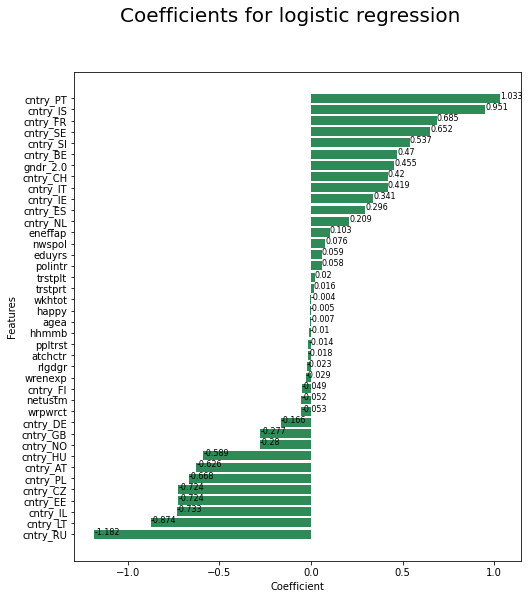

In [111]:
#visualize the coef df 

fig = plt.figure(figsize=(8,9))

for index, value in enumerate(lr_coefs.Coefficient):
    plt.text(value, index, str(round(value,3)), fontsize = 8)
        
fig.suptitle('Coefficients for logistic regression', fontsize = 20)
plt.barh(lr_coefs.index, lr_coefs.Coefficient, color = "seagreen")
plt.ylabel('Features')
plt.xlabel('Coefficient')

plt.savefig('Viz/coef_lr.png', dpi = 300, bbox_inches = "tight")
plt.show()

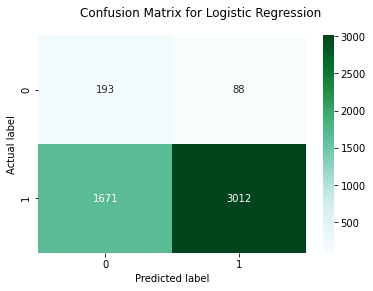

In [112]:
#construct a confusion matrix to identify classification error

cm_lr = confusion_matrix(ytest, lr_pred)

#visualize the cm

sns.heatmap(cm_lr, cmap = 'BuGn', annot = True, fmt = 'd')
plt.suptitle("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.savefig("Viz/cm_lr.png", dpi = 300)

#### Decision Tree 

In [113]:
#train the data with a range of tree depths
dt = DecisionTreeClassifier()
train_scores, test_scores = validation_curve(dt, X_resampled, y_resampled, param_name='max_depth',
                                            param_range=np.arange(1, 11), cv=5)  

In [114]:
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_mean #check the performance 

array([0.42949917, 0.35948773, 0.30883096, 0.30364331, 0.28290589,
       0.2856362 , 0.26696351, 0.29572759, 0.32065045, 0.35449412])

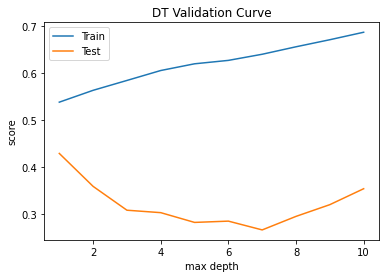

In [115]:
fig1 = plt.figure() #plot the curve
plt.plot(np.arange(1,11), train_mean, label='Train')
plt.plot(np.arange(1,11), test_mean, label='Test')
plt.xlabel('max depth')
plt.ylabel('score')
plt.title('DT Validation Curve')
plt.legend()
plt.show()

#The decision tree does not perform well


In [116]:
dt = DecisionTreeClassifier(max_depth=2, random_state=101)  

In [117]:
dt.fit(X_resampled, y_resampled)

DecisionTreeClassifier(max_depth=2, random_state=101)

In [118]:
dt.score(Xtest, ytest) #perform worse than a random guess 

0.4536663980660757

In [119]:
#predict
dt_pred = dt.predict(Xtest)

In [120]:
f1_score(ytest, dt_pred)

0.6019958908130321

In [121]:
roc_auc_score(ytest, dt_pred)

0.5766348031001814

In [139]:
precision_score(ytest, dt_pred)

0.9624589394650399

In [140]:
recall_score(ytest, dt_pred)

0.43796711509715996

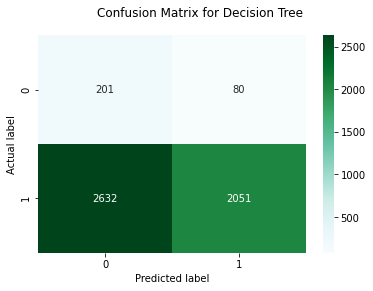

In [123]:
#confusion matrix

cm_dt = confusion_matrix(ytest, dt_pred)
sns.heatmap(cm_dt, cmap = 'BuGn', annot = True, fmt = 'd')
plt.suptitle("Confusion Matrix for Decision Tree")
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.savefig("Viz/cm_dt.png", dpi = 300)

#the false positive is a predominent classification mistake 

#### Random Forest 

In [124]:
rf = RandomForestClassifier(max_depth=4, random_state=101)

In [125]:
rf.fit(X_resampled, y_resampled)

RandomForestClassifier(max_depth=4, random_state=101)

In [126]:
rf.score(Xtest, ytest)

0.6762691377921032

In [127]:
rf_pred = rf.predict(Xtest)

In [128]:
f1_score(ytest, rf_pred)

0.7974284633808142

In [129]:
roc_auc_score(ytest, rf_pred)

0.6829065986383701

In [141]:
precision_score(ytest, rf_pred)

0.9732307692307692

In [143]:
recall_score(ytest, rf_pred)

0.6754217382020072

In [130]:
rf.feature_importances_

array([0.03411412, 0.00994296, 0.00545447, 0.02910778, 0.02614409,
       0.03767832, 0.0232755 , 0.01881181, 0.00499745, 0.13482382,
       0.0235569 , 0.01262625, 0.00632464, 0.01662882, 0.13708093,
       0.07380007, 0.08147579, 0.00574029, 0.00462868, 0.00405049,
       0.03134242, 0.        , 0.02587563, 0.00304209, 0.00025825,
       0.01960024, 0.00056844, 0.00250579, 0.01114064, 0.05050116,
       0.01201289, 0.0059396 , 0.01789932, 0.00203193, 0.00030188,
       0.00392317, 0.01202835, 0.09037525, 0.01818908, 0.00220067])

In [131]:
rf_fi = pd.DataFrame({'feature_importance': rf.feature_importances_}, 
          index=X.columns).sort_values(by='feature_importance', ascending=True)

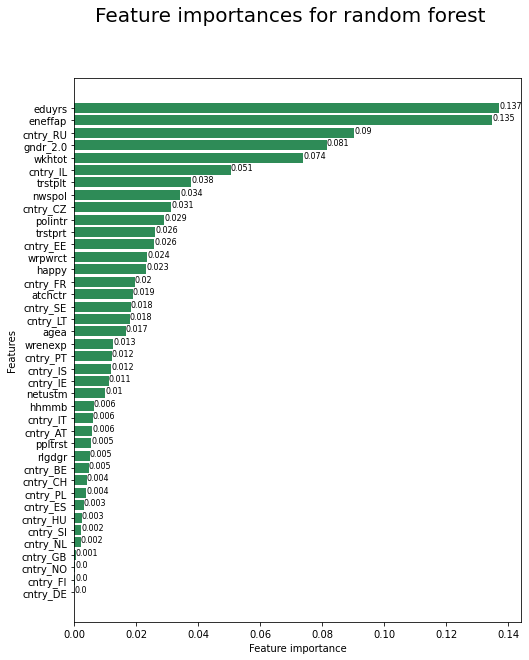

In [134]:
fig = plt.figure(figsize=(8,10))
fig.suptitle('Feature importances for random forest', fontsize = 20)
plt.barh(rf_fi.index, rf_fi.feature_importance, color = "seagreen")
plt.ylabel('Features')
plt.xlabel('Feature importance')
for index, value in enumerate(rf_fi.feature_importance):
    plt.text(value, index, str(round(value,3)), fontsize = 8)
plt.savefig('Viz/fi_rf.png', dpi = 300, bbox_inches = "tight")
plt.show()

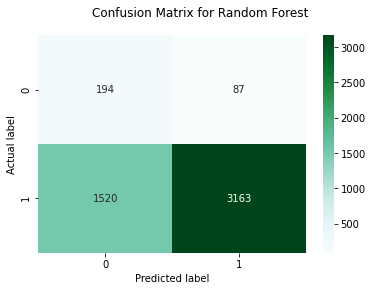

In [135]:
cm_rf = confusion_matrix(ytest, rf_pred)

sns.heatmap(cm_rf, cmap = 'BuGn', annot = True, fmt = 'd')
plt.suptitle("Confusion Matrix for Random Forest")
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.savefig("Viz/cm_rf.png", dpi = 300)